In [1]:
import os
import pandas as pd
import geopandas as gpd
import h3
import seaborn as sns
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from shapely.geometry import Polygon, Point
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import numpy as np
from matplotlib_scalebar.scalebar import ScaleBar

# this lets us plot the boundaries of H3 hexagons as Shapely Polygons
# takes in an h3 hash ID 
# returns a Shapely Polygon
def add_geometry(row):
    points = h3.h3_to_geo_boundary(row, True)
    return Polygon(points)

### Loading the Data

In [2]:
# get both csvs
bird_counts = pd.read_csv('./data/all_bird_counts.csv')
crow_counts = pd.read_csv('./data/crow_counts.csv')

# join the dataframes
all_birds = pd.merge(bird_counts, crow_counts, on='h3_10', how='left')
print(len(all_birds))

# fill all spots where there weren't crow observations
all_birds = all_birds.fillna(value=0)

5158


In [3]:
# h3 size 10 is pretty small, so to give ourselves some more resolution options, let's upsample a bit
# we will add h3 size 9 and size 8 to have those options to play with later
all_birds['h3_9'] = [h3.h3_to_parent(h) for h in all_birds['h3_10']]
all_birds['h3_8'] = [h3.h3_to_parent(h) for h in all_birds['h3_9']]

### Data Analysis

In [4]:
# let's focus on h3 size 9
# let's resample the data at that resolution
all_birds = all_birds.groupby(['h3_9'])[['crows', 'all_birds']].sum().reset_index()

<AxesSubplot: xlabel='ratio', ylabel='Count'>

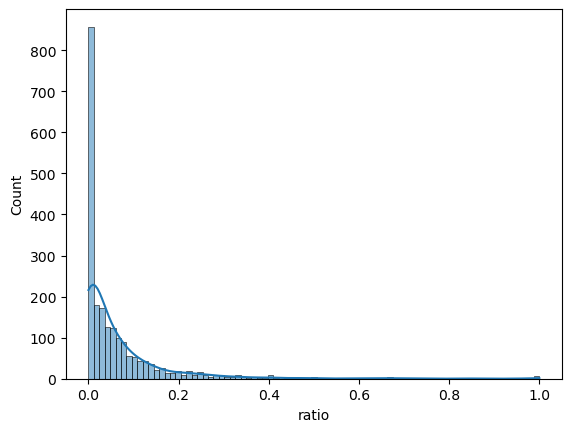

In [17]:
# let's find the ratio of crow sightings to all bird sightings in each hexagon
# this lets us find places where there are more crows relative to all birds
# or at least... relative to all bird sightings
# I have my doubts about crows sightings because they are such common birds - I imagine that means
# they are a little bit under reported, but who knows. Analysis for another time, I suppose
all_birds['ratio'] = all_birds['crows']/all_birds['all_birds']

# let's take a quick look see at this distribution
fig, ax = plt.subplots(1, 1)
sns.histplot(all_birds, x='ratio', kde=True, ax=ax)

In [6]:
all_birds['ratio'].describe()

count    2132.000000
mean        0.064653
std         0.115579
min         0.000000
25%         0.000000
50%         0.025735
75%         0.078471
max         1.000000
Name: ratio, dtype: float64

In [7]:
# alright, now that we have this ratio, lets decide what makes an area "prone to crows"
# I'm going to take the top 34% of hexagons in terms of crow prominence 
# that means the top ~1/3 of all hexagons in terms of crow ratio
higher_percentile = 0.66
high = all_birds['ratio'].quantile([higher_percentile]).values[0]
print(f'{1-higher_percentile:.0%} of hexagons have a crow ratio higher than {high:.2f}')

# now lets subset the data to only this high percentile
all_birds = all_birds[all_birds['ratio'] > high]

34% of hexagons have a crow ratio higher than 0.06


## Plotting the data

In [8]:
# okay, we have to make this plottable by geopandas
# first we add a geometry column by getting a Shapely Polygon for each H3 hash
all_birds['geometry'] = all_birds['h3_9'].apply(add_geometry)

# then we convert to a geodataframe and fix the coordinate systems
# the Shapely Polygons are in WGS 83 coordinate system first. We use that to start.
# then we convert to Web Mercator so we can add a basemap 
all_birds = gpd.GeoDataFrame(all_birds)
all_birds = all_birds.set_crs(epsg=4326)
all_birds = all_birds.to_crs(epsg=3857)

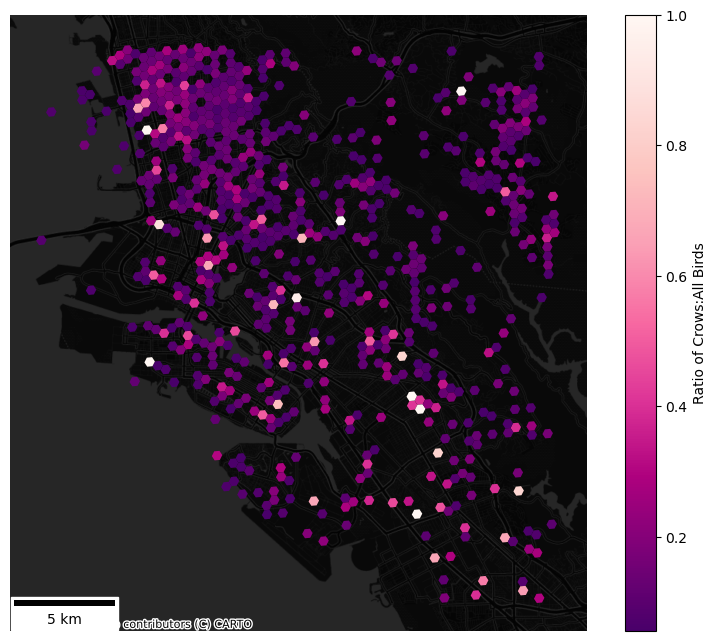

In [37]:
# initial plot, just to see what we've got
# this plot could answer questions like "where are the highest crow ratios?"
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,8)
ax = all_birds.plot(column='ratio', ax=ax, cmap='RdPu_r', 
                    legend=True, legend_kwds={'label':'Ratio of Crows:All Birds'})

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatterNoLabels)
ax.set_axis_off()

plt.show

## The Crow Map

In [10]:
# make a matplotlib marker with an svg file
def make_marker(file_path):
    # parse the svg
    path, attributes = svg2paths(file_path)
    marker = parse_path(attributes[0]['d'])
    
    # get it indexed so matplotlib can plot it
    marker.vertices -= marker.vertices.mean(axis=0)
    
    # rotate it and flip it
    marker = marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    marker = marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    
    # return the path object that is now plottable with matplotlib!
    return marker

In [11]:
# make the crow markers from the svgs
# they are in the assets folder
# there is one marker per svg
folder = './assets/crows/'
files = os.listdir(folder)

crow_markers = [None] * len(files)

# get all the markers and add them to the list
for i, f in enumerate(files):
    crow_markers[i] = make_marker(f'{folder}{f}')

In [12]:
# convert the h3s into coordinates where we can plot the crows
# plot the crows at the centroids of each cell
# we will convert these lat/lng coordinate pairs from WGS84 to Web Mercator 
# so we can add a basemap
# to do this we make a GeoSeries of the centroids
cell_centers = [h3.h3_to_geo(h) for h in all_birds['h3_9']]

s = gpd.GeoSeries([Point(c[1], c[0]) for c in cell_centers], crs="EPSG:4326")
s = s.to_crs(epsg=3857)

In [13]:
# make the centroid Series into a data frame 
# this allows us to add a column that specifies which marker we will use
# we will randomly assign markers to each row 
crows_plot = gpd.GeoDataFrame(geometry=s)
crows_plot['marker'] = np.random.randint(0, len(crow_markers), size=len(s))

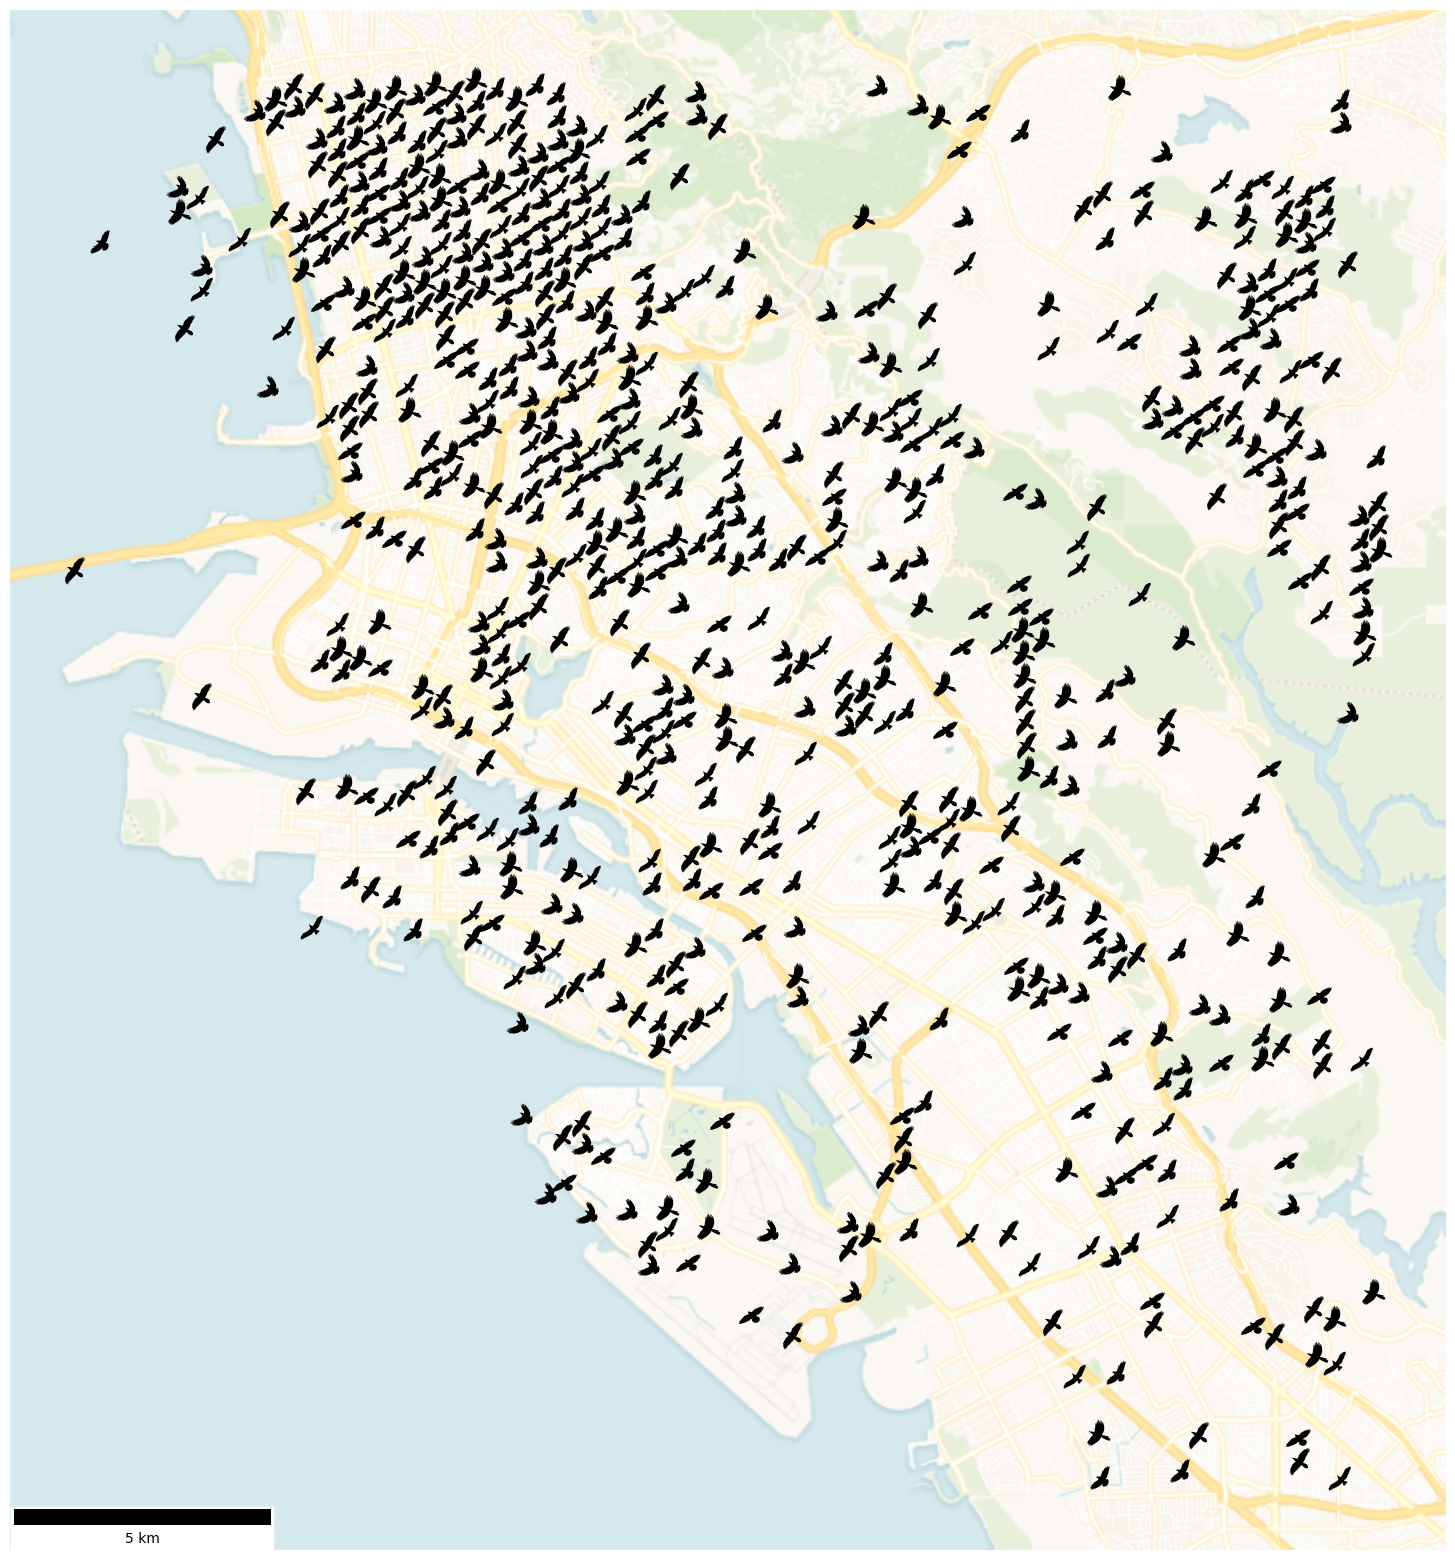

In [17]:
# Plot the dang thing!!
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(20,20)

# loop through the markers and plot the crows with that marker
# there could be a better way to do this probably but hey, this works for now!
for i,m in enumerate(crow_markers):
    ax = crows_plot[crows_plot['marker'] == i].plot(ax=ax, facecolor='black', 
                                                    lw=0, marker=m, markersize=400)
    
# add a scale bar
ax.add_artist(ScaleBar(1, location='lower left'))

# add the basemap and turn off the axis labels (for making it prettier)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off()

plt.show

# save the plot as a PDF for editing capacity in Adobe Illustrator
plt.savefig("crow_map.png")